### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [387]:
%matplotlib inline

In [388]:
from pathlib import Path
import requests
PATH_file =Path( r'D:\studydata\machine_bild_learn\AI\资料\缺陷检测章节资料\PyTorch基础\2-神经网络实战分类与回归任务\神经网络实战分类与回归任务\data\mnist\mnist.pkl.gz')


In [389]:
import pickle
import gzip

with gzip.open((PATH_file).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [390]:
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
from tensorflow import keras
from tensorflow.keras import layers,models

Tensor Flow Version: 2.13.0


784是mnist数据集每个样本的像素点个数

(50000, 784)
0


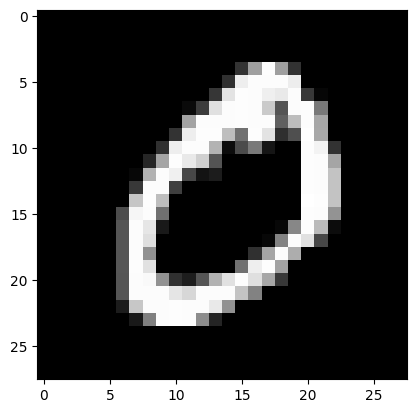

In [391]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[1].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(y_train[1])

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [392]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
#x_train, x_train.shape, y_train.min(), y_train.max()
#print(x_train, y_train)
print(n,c)
print(x_train.shape)
print(y_train.shape)
print(y_train.min(), y_train.max())

50000 784
torch.Size([50000, 784])
torch.Size([50000])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [393]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [394]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
print(xb.shape)
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)
print(bias)
print(loss_func(model(xb), yb))

torch.Size([64, 784])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
tensor(15.7623, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [395]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [396]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [397]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0288,  0.0161, -0.0061,  ..., -0.0007, -0.0313, -0.0076],
        [ 0.0178, -0.0323,  0.0007,  ...,  0.0121, -0.0211, -0.0063],
        [-0.0100,  0.0346, -0.0222,  ..., -0.0273, -0.0158,  0.0228],
        ...,
        [-0.0344,  0.0295, -0.0025,  ..., -0.0330,  0.0269, -0.0215],
        [ 0.0273, -0.0050, -0.0340,  ..., -0.0198, -0.0263,  0.0011],
        [ 0.0170, -0.0272, -0.0302,  ..., -0.0093,  0.0100,  0.0315]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 4.8337e-03,  3.2469e-02, -2.0903e-02, -3.3078e-04, -5.6197e-03,
         1.8316e-02,  2.2975e-03, -1.8621e-02, -1.3229e-02,  5.8254e-03,
         3.4873e-02,  2.0578e-02,  5.8640e-03, -6.7475e-03, -7.5489e-03,
        -1.4746e-02, -1.9950e-02, -1.8117e-02, -2.9267e-02,  1.5712e-02,
        -3.3653e-02, -1.9535e-02,  3.0491e-02, -2.3013e-02, -3.2140e-02,
        -3.4459e-02,  1.1670e-02,  2.7615e-02,  1.7720e-03, -2.8581e-02,
      

### 使用TensorDataset和DataLoader来简化

In [398]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [399]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [400]:
import numpy as np
#steps:训练次数(epoch)
#model:模型(Mnist_NN)
#loss_func:损失函数(F.cross_entropy)
#opt:优化器(optim.SGD)
#train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
#train_dl:训练集(train_ds = TensorDataset(x_train, y_train))
#valid_dl:验证集(valid_ds = TensorDataset(x_valid, y_valid))
train_losses = []  # List to store training losses
valid_losses = []  # List to store validation losses
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss=loss_batch(model, loss_func, xb, yb, opt)
            tarinloss,trainnum = zip(*[loss])
            train_loss=np.sum(np.multiply(tarinloss, trainnum)) / np.sum(trainnum)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        valid_losses.append(val_loss)
        print('当前step:'+f'{step+1}/{steps}', f'Training Loss: {train_loss:.4f}','验证集损失：'+str(val_loss))


In [401]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [402]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [403]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)
#print(train_loss,val_loss)

当前step:1/25 Training Loss: 2.2750 验证集损失：2.278624062728882
当前step:2/25 Training Loss: 2.2755 验证集损失：2.242380581665039
当前step:3/25 Training Loss: 2.2217 验证集损失：2.1873171924591066
当前step:4/25 Training Loss: 2.1337 验证集损失：2.0968357955932615
当前step:5/25 Training Loss: 1.9107 验证集损失：1.949976919555664
当前step:6/25 Training Loss: 1.7960 验证集损失：1.7360699993133546
当前step:7/25 Training Loss: 1.6018 验证集损失：1.4718210008621215
当前step:8/25 Training Loss: 1.1552 验证集损失：1.2125050659179688
当前step:9/25 Training Loss: 1.0455 验证集损失：1.0076023187637329
当前step:10/25 Training Loss: 1.2922 验证集损失：0.8604043290138245
当前step:11/25 Training Loss: 0.6934 验证集损失：0.7548569446563721
当前step:12/25 Training Loss: 0.6181 验证集损失：0.6772268054962158
当前step:13/25 Training Loss: 0.7560 验证集损失：0.6182123139381409
当前step:14/25 Training Loss: 0.6540 验证集损失：0.5726623079299927
当前step:15/25 Training Loss: 0.7111 验证集损失：0.5364098049163818
当前step:16/25 Training Loss: 0.7932 验证集损失：0.5067625049591065
当前step:17/25 Training Loss: 0.2974 验证集损失：0.482284669

In [404]:
#train_losses

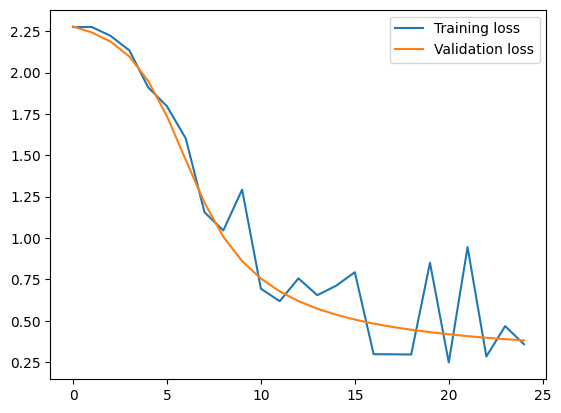

In [405]:
pyplot.plot(train_losses, label='Training loss')
pyplot.plot(valid_losses, label='Validation loss')
pyplot.legend()
pyplot.show()


Label: tensor(3) , Predicted: 3


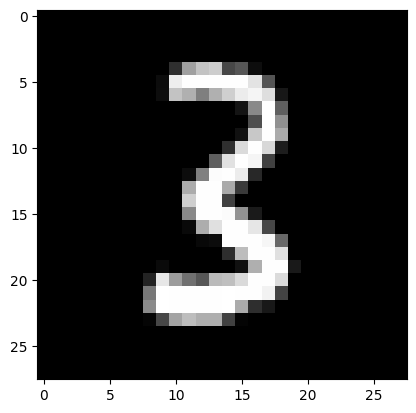

In [406]:
#predict
def predict_image(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = valid_ds[0]
pyplot.imshow(img.reshape((28,28)), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))


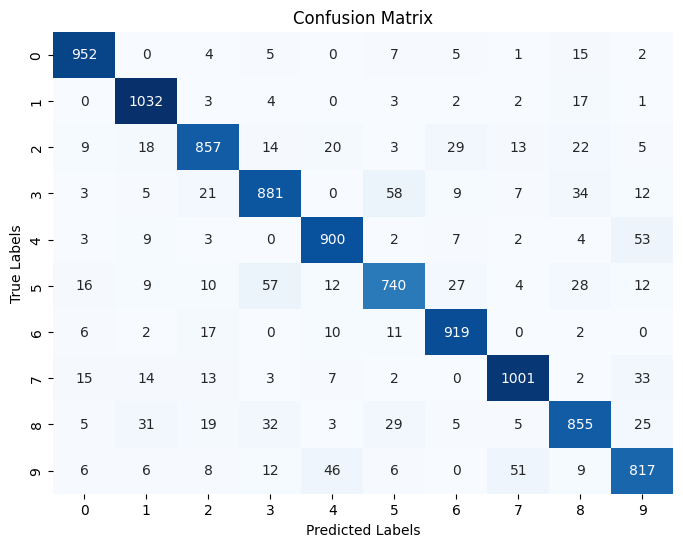

In [407]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Create empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
model.eval()

# Iterate through the DataLoader
for xb, yb in valid_dl:
    # Make predictions
    with torch.no_grad():
        yb_pred = model(xb)
    _, preds = torch.max(yb_pred, dim=1)
    
    # Append true and predicted labels to the lists
    true_labels.extend(yb.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Optionally, you can create a heatmap to visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
